In [2]:
from UZ_utils import *
from a4_utils import *
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import random

1 a 

In [8]:
def gausian_kernel(sigma):
    N = int(2*np.ceil(3*sigma)+1)
    x = np.arange(-N,N+1)

    kernel = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-x**2/(2*sigma**2))
    kernel = kernel/np.sum(kernel)

    return kernel
def gaussdx(sigma):
    N = int(2*np.ceil(3*sigma)+1)
    x = np.arange(-N,N+1)

    kernel = -x/(np.sqrt(2*np.pi)*sigma**3)*np.exp(-x**2/(2*sigma**2))
    kernel = kernel/np.sum(np.abs(kernel))

    return kernel

def gaussderivatives(image, sigma):
    k1=gausian_kernel(sigma)
    G=k1.reshape(1,-1)
    GT=G.T


    G=np.flip(G)
    GT=np.flip(GT)

    k2=gaussdx(sigma)

    D=k2.reshape(1,-1)
    Dt=D.T


    D=np.flip(D)
    Dt=np.flip(Dt)

    Ix=cv2.filter2D(cv2.filter2D(image, cv2.CV_64F, D), cv2.CV_64F, GT)
    Iy=cv2.filter2D(cv2.filter2D(image, cv2.CV_64F, G), cv2.CV_64F, Dt)

    return (Ix,Iy)

In [9]:
def nonmaxima_suppression(det,threshold,box_size):
    h,w=det.shape

    new_det=np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            if det[i,j]>threshold:
                box=det[i-box_size//2:i+box_size//2+1,j-box_size//2:j+box_size//2+1]
                if box.size>0:
                    max_val=np.max(box)
                else:
                    max_val=0

                if det[i,j]==max_val:
                    new_det[i,j]=1
    return new_det

In [10]:
def hessian_points(I,sigma,threshold):

    Ix,Iy=gaussderivatives(I,sigma)

    Ixx,Ixy=gaussderivatives(Ix,sigma)
    Iyx,Iyy=gaussderivatives(Iy,sigma)

    detH = Ixx*Iyy-Ixy*Iyx
    
    return detH

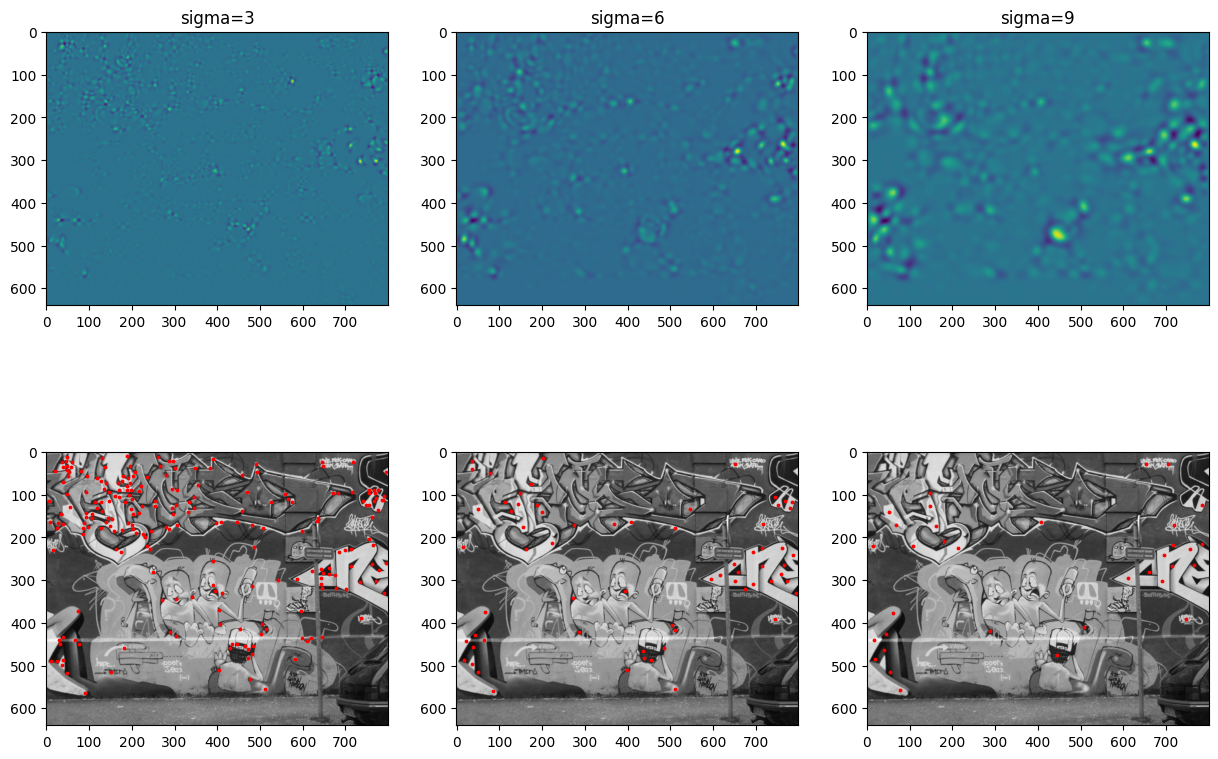

In [11]:
#open the image grey scale
image = imread_gray('data/graf/graf_a.jpg')
thresh=0.004

#compute the hessian points
det3 = hessian_points(image, 3, thresh)
det6 = hessian_points(image, 6, thresh)
det9 = hessian_points(image, 9, thresh)

#make 3 wide and 2 high 
fig, axs = plt.subplots(2, 3,figsize=(15,10))

#plot the dets int the first row
axs[0,0].imshow(det3)
axs[0,0].set_title('sigma=3')
axs[0,1].imshow(det6)
axs[0,1].set_title('sigma=6')
axs[0,2].imshow(det9)
axs[0,2].set_title('sigma=9')

det3=nonmaxima_suppression(det3,thresh,2)
det6=nonmaxima_suppression(det6,thresh,2)
det9=nonmaxima_suppression(det9,thresh,2)

#add scatter plot with the points the shape of X
axs[1,0].imshow(image,cmap='gray')
axs[1,0].scatter(np.where(det3==1)[1],np.where(det3==1)[0],s=3,c='r')
axs[1,1].imshow(image,cmap='gray')
axs[1,1].scatter(np.where(det6==1)[1],np.where(det6==1)[0],s=3,c='r')
axs[1,2].imshow(image,cmap='gray')
axs[1,2].scatter(np.where(det9==1)[1],np.where(det9==1)[0],s=3,c='r')

plt.show()

1 b

In [12]:
def harris_points(I, sigma, thresh=0):

    harris = np.zeros(I.shape)

    sigma2 = 1.6 * sigma
    alpha = 0.06

    G = gausian_kernel(sigma2)
    G = G.reshape(1, -1)
    GT = G.T

    Ix,Iy=gaussderivatives(I,sigma)
    
    C = np.zeros((I.shape[0], I.shape[1], 2, 2))

    C[:, :, 0, 0] = cv2.filter2D(cv2.filter2D(Ix * Ix, cv2.CV_64F, G), cv2.CV_64F, GT) #G sigma2 * Ix^2
    C[:, :, 0, 1] = cv2.filter2D(cv2.filter2D(Ix * Iy, cv2.CV_64F, G), cv2.CV_64F, GT) #G sigma2 * Ix * Iy
    C[:, :, 1, 0] = cv2.filter2D(cv2.filter2D(Ix * Iy, cv2.CV_64F, G), cv2.CV_64F, GT) #G sigma2 * Ix * Iy
    C[:, :, 1, 1] = cv2.filter2D(cv2.filter2D(Iy * Iy, cv2.CV_64F, G), cv2.CV_64F, GT) #G sigma2 * Iy^2

    
    det = C[:, :, 0, 0] * C[:, :, 1, 1] - C[:, :, 0, 1] * C[:, :, 1, 0]
    trace = C[:, :, 0, 0] + C[:, :, 1, 1]
    
    harris = det - alpha * trace * trace    #feature points

    return harris

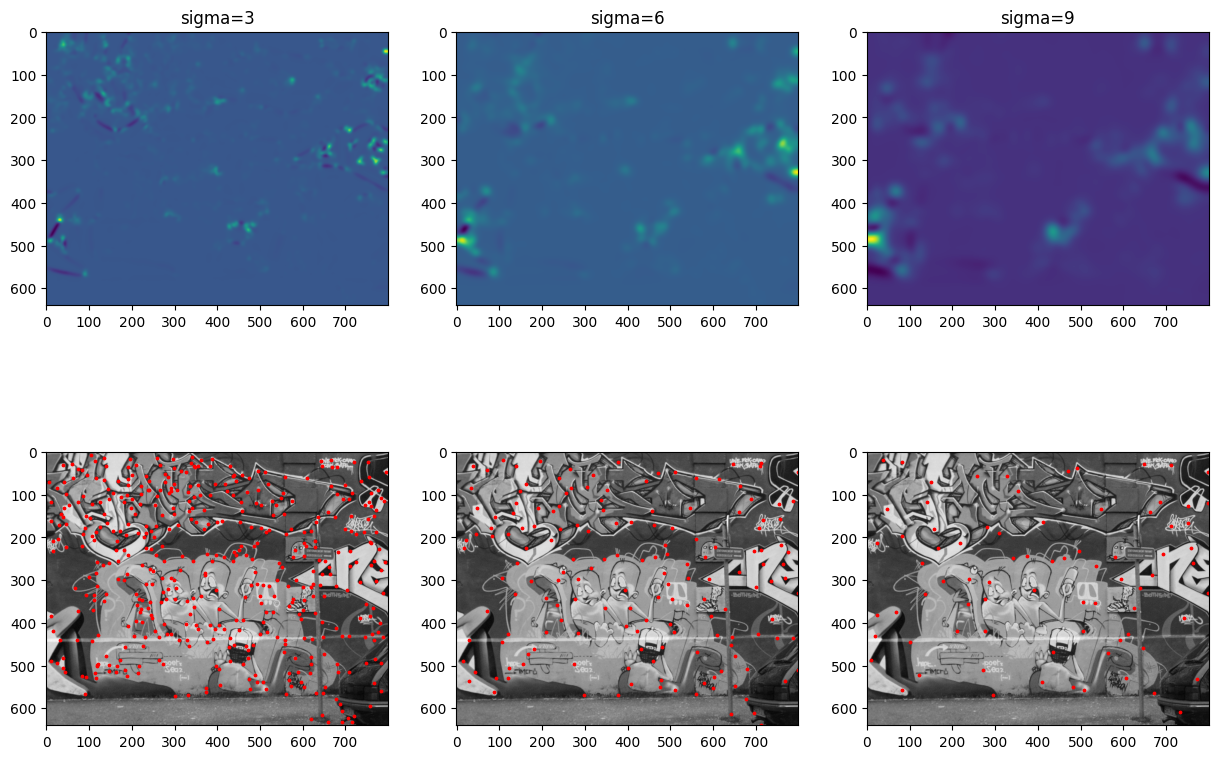

In [13]:
image = imread_gray('data/graf/graf_a.jpg')
thresh=0.000001 #1e−6
sigma=3


det3 = harris_points(image, 3, thresh)
det6 = harris_points(image, 6, thresh)
det9 = harris_points(image, 9, thresh)

fig, axs = plt.subplots(2, 3,figsize=(15,10))

axs[0,0].imshow(det3)
axs[0,0].set_title('sigma=3')
axs[0,1].imshow(det6)
axs[0,1].set_title('sigma=6')
axs[0,2].imshow(det9)
axs[0,2].set_title('sigma=9')

det3=nonmaxima_suppression(det3,thresh,2)
det6=nonmaxima_suppression(det6,thresh,2)
det9=nonmaxima_suppression(det9,thresh,2)

axs[1,0].imshow(image,cmap='gray')
axs[1,0].scatter(np.where(det3==1)[1],np.where(det3==1)[0],s=3,c='r')
axs[1,1].imshow(image,cmap='gray')
axs[1,1].scatter(np.where(det6==1)[1],np.where(det6==1)[0],s=3,c='r')
axs[1,2].imshow(image,cmap='gray')
axs[1,2].scatter(np.where(det9==1)[1],np.where(det9==1)[0],s=3,c='r')

plt.show()

2 a

In [14]:
def find_correspondences(desc1,desc2,ratio=False):

    pairs=[] 
    #za vsak descriptor v desc1
    for i in range(len(desc1)):
        
        d1=desc1[i]

        #za vsak descriptor v desc2
        distances=np.zeros(len(desc2))
        for j in range(len(desc2)):
            d2=desc2[j]
            hellinger_distance=np.sqrt(np.sum((np.sqrt(d1)-np.sqrt(d2))**2))
            distances[j]=hellinger_distance

        #najmanjsiga
        if ratio: 
            sorted_distances=np.sort(distances)
            ratio=sorted_distances[0]/sorted_distances[1]
            if ratio<0.9:
                smallest_index=np.argmin(distances)
                pairs.append((i,smallest_index))
            
        else:
            smallest_index=np.argmin(distances)
            pairs.append((i,smallest_index))
        

            

    return pairs

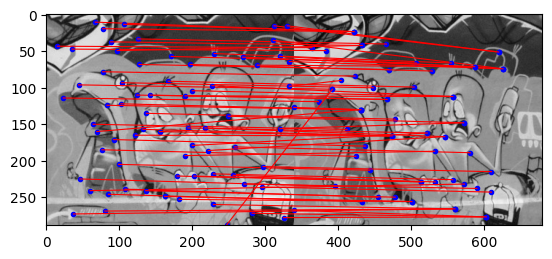

In [15]:
I1=imread_gray('data/graf/graf_a_small.jpg')
I2=imread_gray('data/graf/graf_b_small.jpg')

thresh = 0.0000001
sigma = 4

#get harris points
harris1 = harris_points(I1, sigma, thresh)
harris2 = harris_points(I2, sigma, thresh)
harris1=nonmaxima_suppression(harris1, thresh, sigma)
harris2=nonmaxima_suppression(harris2, thresh, sigma)
points1=np.where(harris1==1) #x,y
points2=np.where(harris2==1) #x,y

#compute simple descriptors
simple_descriptors1 = simple_descriptors(I1, points1[0], points1[1])
simple_descriptors2 = simple_descriptors(I2, points2[0], points2[1])

#find correspondences
pairs=find_correspondences(simple_descriptors1,simple_descriptors2)

#make two array of points ordered by the pairs, pts1, pts2: Nx2 arrays of coordinates of feature points for each image (first columnt is x, second is y coordinates)
pts1=np.zeros((len(pairs),2))
pts2=np.zeros((len(pairs),2))
for i in range(len(pairs)):
    pts1[i,:]=points1[1][pairs[i][0]],points1[0][pairs[i][0]]
    pts2[i,:]=points2[1][pairs[i][1]],points2[0][pairs[i][1]]

#plot the points
display_matches(I1, pts1, I2, pts2)

2 b

In [16]:
def find_matches(I1,I2,sigma,thresh,ratio=False):

    #get harris points
    harris1 = harris_points(I1, sigma, thresh)
    harris2 = harris_points(I2, sigma, thresh)
    harris1=nonmaxima_suppression(harris1, thresh, sigma)
    harris2=nonmaxima_suppression(harris2, thresh, sigma)

    points1=np.where(harris1==1) #x,y
    points2=np.where(harris2==1) #x,y

    simple_descriptors1 = simple_descriptors(I1, points1[0], points1[1])
    simple_descriptors2 = simple_descriptors(I2, points2[0], points2[1])

    #find correspondences
    pairs1=find_correspondences(simple_descriptors1,simple_descriptors2,ratio)
    pairs2=find_correspondences(simple_descriptors2,simple_descriptors1,ratio)

    #print(pairs2)
    pairs2=[t[::-1] for t in pairs2]
    #print(pairs2)

    #find symmetric correspondences
    symmetric_pairs=[]
    for i in range(len(pairs1)):
        if pairs1[i] in pairs2:
            symmetric_pairs.append(pairs1[i])

    #make two array of points ordered by the pairs, pts1, pts2: Nx2 arrays of coordinates of feature points for each image (first columnt is x, second is y coordinates)
    pts1=np.zeros((len(symmetric_pairs),2))
    pts2=np.zeros((len(symmetric_pairs),2))
    for i in range(len(symmetric_pairs)):
        pts1[i,:]=points1[1][symmetric_pairs[i][0]],points1[0][symmetric_pairs[i][0]]
        pts2[i,:]=points2[1][symmetric_pairs[i][1]],points2[0][symmetric_pairs[i][1]]

    return pts1,pts2

40


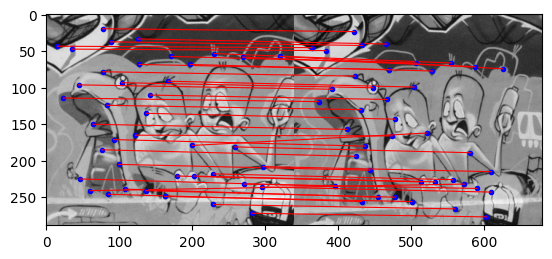

In [17]:
I1=imread_gray('data/graf/graf_a_small.jpg')
I2=imread_gray('data/graf/graf_b_small.jpg')

pts1,pts2=find_matches(I1,I2,sigma,thresh)

print(len(pts1))

display_matches(I1, pts1, I2, pts2)

2 c

21


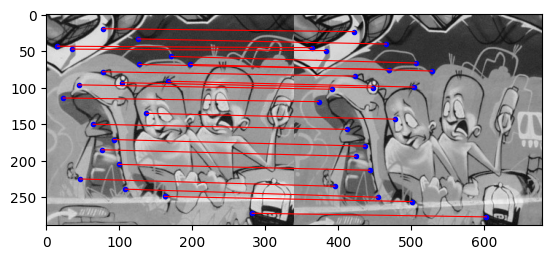

In [18]:
I1=imread_gray('data/graf/graf_a_small.jpg')
I2=imread_gray('data/graf/graf_b_small.jpg')

pts1,pts2=find_matches(I1,I2,sigma,thresh,True)

print(len(pts1))

display_matches(I1, pts1, I2, pts2)

2 d

In [223]:
def calculate_gradients(image):
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.arctan2(dy, dx)
    
    return magnitude, orientation

def calculate_sift_descriptor(image, x_cords, y_cords):
    magnitude, orientation = calculate_gradients(image)

    # obrnt sliko na podlagi vseh gradientov...
    
    descriptor = np.zeros((len(x_cords), 4, 4, 8))
    
    for i, (x, y) in enumerate(zip(x_cords, y_cords)):

        #vsak kvadrat v 4x4 je velikosti 8x8 pixlov
        region_size = 4 #*2
        region_magnitude = magnitude[y-region_size:y+region_size, x-region_size:x+region_size]
        region_orientation = orientation[y-region_size:y+region_size, x-region_size:x+region_size]
        
        #za vsak kvadrat
        for r in range(4):
            for c in range(4):
                cell_magnitude = region_magnitude[r*4:(r+1)*4, c*4:(c+1)*4]
                cell_orientation = region_orientation[r*4:(r+1)*4, c*4:(c+1)*4]

                #print(cell_orientation)
                #print(cell_magnitude)
                
                #histogram
                histogram, _ = np.histogram(cell_orientation, bins=8, range=(0, 2*np.pi), weights=cell_magnitude)
                
                descriptor[i, r, c, :] = histogram
    
    # gaussian weighting...

    # Flatten the descriptor for each keypoint
    descriptor = descriptor.reshape(len(x_cords), -1)

    #normalization...
    
    return descriptor

In [226]:
def find_matchesSIFT(I1,I2,sigma,thresh,ratio=False):

    #get harris points
    harris1 = harris_points(I1, sigma, thresh)
    harris2 = harris_points(I2, sigma, thresh)
    harris1=nonmaxima_suppression(harris1, thresh, sigma)
    harris2=nonmaxima_suppression(harris2, thresh, sigma)

    points1=np.where(harris1==1) #y,x
    points2=np.where(harris2==1) #y,x

    simple_descriptors1 = calculate_sift_descriptor(I1, points1[0], points1[1])
    simple_descriptors2 = calculate_sift_descriptor(I2, points2[0], points2[1])

   #print(simple_descriptors1)

    #find correspondences
    pairs1=find_correspondences(simple_descriptors1,simple_descriptors2,ratio)
    pairs2=find_correspondences(simple_descriptors2,simple_descriptors1,ratio)

    #print(pairs2)
    pairs2=[t[::-1] for t in pairs2]
    #print(pairs2)

    #find symmetric correspondences
    symmetric_pairs=[]
    for i in range(len(pairs1)):
        if pairs1[i] in pairs2:
            symmetric_pairs.append(pairs1[i])

    #make two array of points ordered by the pairs, pts1, pts2: Nx2 arrays of coordinates of feature points for each image (first columnt is x, second is y coordinates)
    pts1=np.zeros((len(symmetric_pairs),2))
    pts2=np.zeros((len(symmetric_pairs),2))
    for i in range(len(symmetric_pairs)):
        pts1[i,:]=points1[1][symmetric_pairs[i][0]],points1[0][symmetric_pairs[i][0]]
        pts2[i,:]=points2[1][symmetric_pairs[i][1]],points2[0][symmetric_pairs[i][1]]

    return pts1,pts2

/var/folders/r_/0ymw_h356pqcpslcb7w07lfd183tlj/T/ipykernel_60759/1884154099.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ratio=sorted_distances[0]/sorted_distances[1]


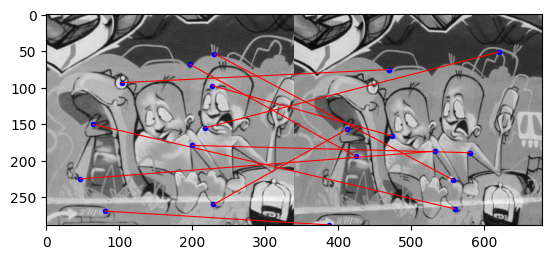

In [227]:
I1=imread_gray('data/graf/graf_a_small.jpg')
I2=imread_gray('data/graf/graf_b_small.jpg')

pts1,pts2=find_matchesSIFT(I1,I2,sigma,thresh,True)

display_matches(I1, pts1, I2, pts2)

2 e

In [16]:
import cv2

video_path = 'video.mov'
cap = cv2.VideoCapture(video_path)

sift = cv2.SIFT_create()

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('keypoints_video.mp4', fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    keypoints, _ = sift.detectAndCompute(gray, None)

    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #cv2.imshow('Video with Keypoints', frame_with_keypoints)

    out.write(frame_with_keypoints)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
#cv2.destroyAllWindows()


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


: 

3 a

In [19]:
def estimate_homography(ptsI1,ptsI2):

    A = np.zeros((2*len(ptsI1),9))
    for i in range(len(ptsI1)):
        x1 = ptsI1[i,0]
        y1 = ptsI1[i,1]
        x2 = ptsI2[i,0]
        y2 = ptsI2[i,1]
        A[2*i]=[x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]
        A[2*i+1]=[0,0,0,x1,y1,1,-y2*x1,-y2*y1,-y2]

    U,S,V = np.linalg.svd(A)

    #zadn stolpec delimo s zadnim el.
    h = V[-1] / V[-1,-1]

    H = h.reshape(3,3)

    return H

In [20]:
def read_points_from_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    pts1 = []
    pts2 = []

    for line in lines:
        values = list(map(int, line.split()))
        pts1.append([values[0], values[1]])
        pts2.append([values[2], values[3]])

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    return pts1, pts2

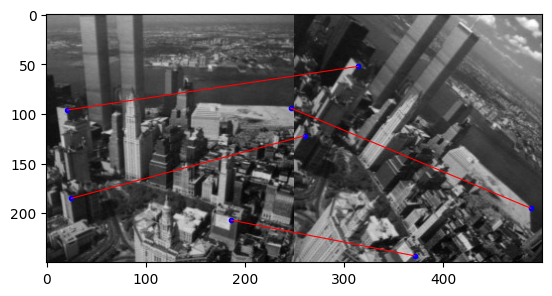

[[3.67922439e-06 1.94045364e-06 2.73291609e-06]
 [2.64169543e-06 4.13433530e-06 3.61606939e-06]
 [4.85626208e-06 3.08333303e-06 0.00000000e+00]]


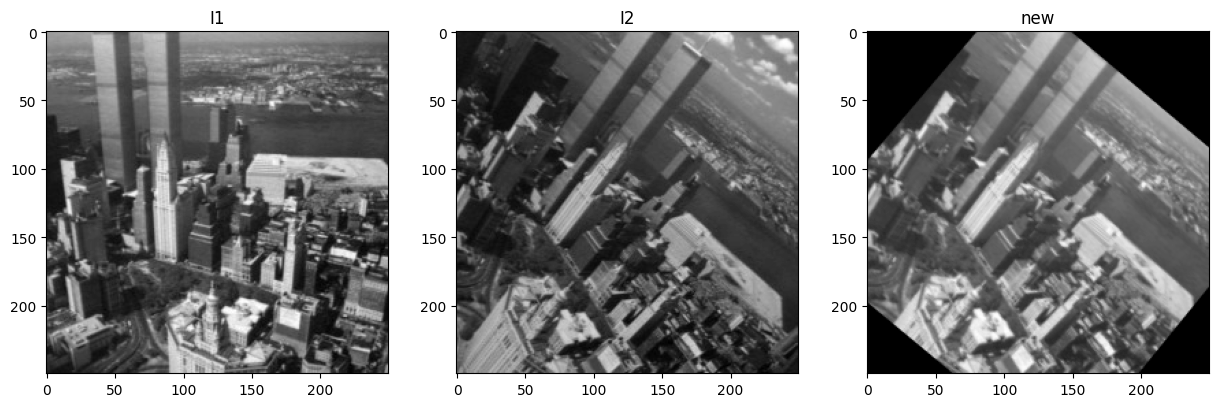

In [21]:
I1=imread_gray('data/newyork/newyork_a.jpg')
I2=imread_gray('data/newyork/newyork_b.jpg')

#read the points
pts1,pts2=read_points_from_file('data/newyork/newyork.txt')

#read H.txt and compare with the estimated H
H_true = np.loadtxt('data/newyork/H.txt')


display_matches(I1, pts1, I2, pts2)

H = estimate_homography(pts1,pts2)
print(np.abs(H_true-H))
 
new = cv2.warpPerspective(I1, H, I1.shape)
fig, axs = plt.subplots(1, 3,figsize=(15,10))
axs[0].imshow(I1,cmap='gray')
axs[0].set_title('I1')
axs[1].imshow(I2,cmap='gray')
axs[1].set_title('I2')
axs[2].imshow(new,cmap='gray')
axs[2].set_title('new')
plt.show()

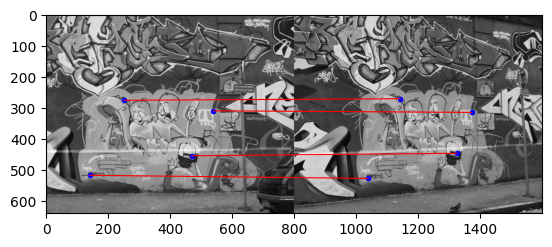

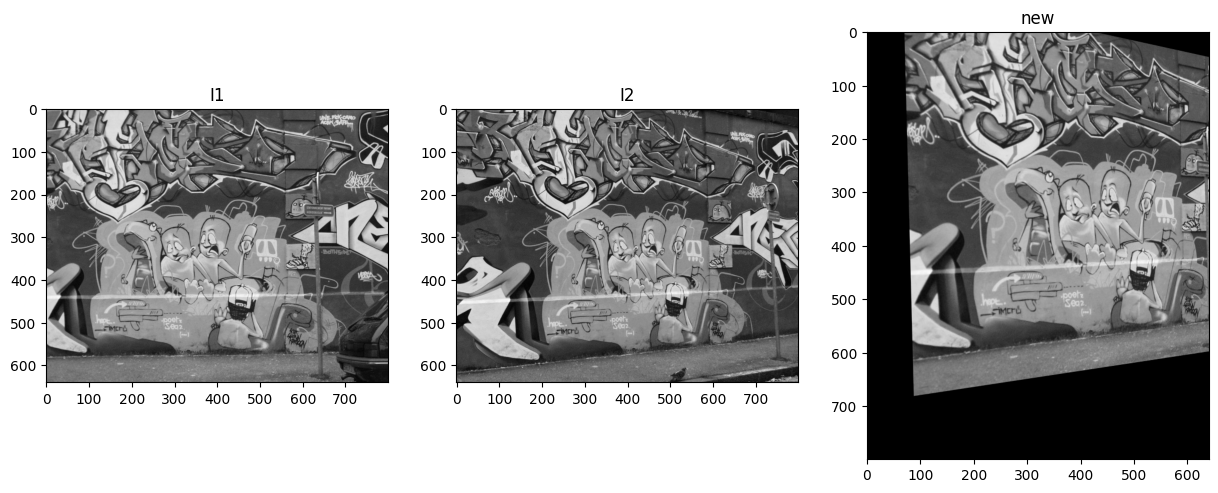

In [22]:
I1=imread_gray('data/graf/graf_a.jpg')
I2=imread_gray('data/graf/graf_b.jpg')

#read the points
pts1,pts2=read_points_from_file('data/graf/graf.txt')

display_matches(I1, pts1, I2, pts2)

H = estimate_homography(pts1,pts2)
 
new = cv2.warpPerspective(I1, H, I1.shape)
fig, axs = plt.subplots(1, 3,figsize=(15,10))
axs[0].imshow(I1,cmap='gray')
axs[0].set_title('I1')
axs[1].imshow(I2,cmap='gray')
axs[1].set_title('I2')
axs[2].imshow(new,cmap='gray')
axs[2].set_title('new')
plt.show()

3 b

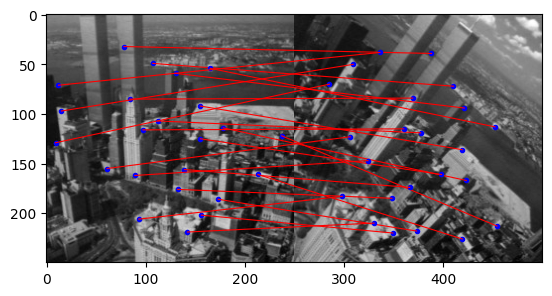

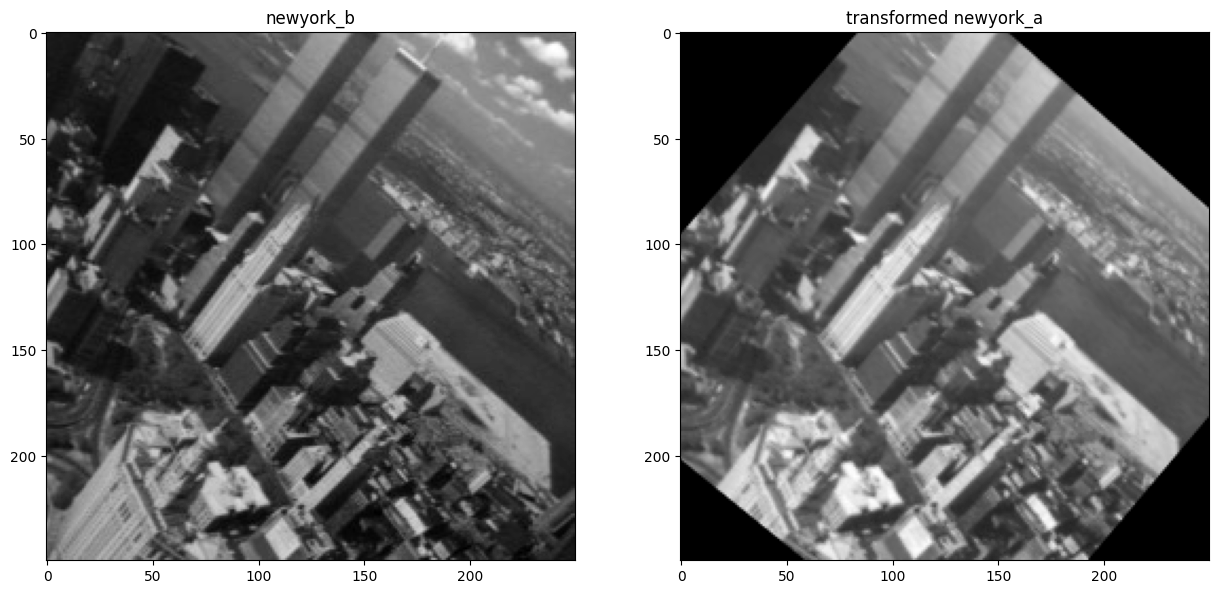

In [147]:
I1=imread_gray('data/newyork/newyork_a.jpg')
I2=imread_gray('data/newyork/newyork_b.jpg')

sigma = 4
thresh = 0.0000001

pts1,pts2=find_matches(I1,I2,sigma,thresh)

display_matches(I1, pts1, I2, pts2)

bestH = None
bestInlierCount = 0

for i in range(100):
    #get 4 random indexes from 0 to len(pts1)
    randomPts = random.sample(range(0, len(pts1)), 4)
    #make two arrays of random points
    randomPts1 = np.zeros((4,2))
    randomPts2 = np.zeros((4,2))
    for j in range(4):
        randomPts1[j,:] = pts1[randomPts[j],:]
        randomPts2[j,:] = pts2[randomPts[j],:]

    H = estimate_homography(randomPts1, randomPts2)
    #find the inliers
    inliersCount = 0
    for j in range(len(randomPts1)):
        x1,y1=randomPts1[j,:]
        x2,y2=randomPts2[j,:]
        x1 = np.array([x1, y1, 1])
        x2 = np.array([x2, y2, 1])
        x1 = x1.reshape(3, 1)
        x2 = x2.reshape(3, 1)
        #calculate the distance use euclidean distance
        distance = np.linalg.norm(np.dot(H, x1) - x2)
        if distance < 2:
            inliersCount += 1
            
    #check if the number of inliers is greater than the best number of inliers
    if inliersCount > bestInlierCount:
        bestInlierCount = inliersCount
        bestH = H
    
    if inliersCount == 4:
        print(i)
        break

#display the matches
new = cv2.warpPerspective(I1, bestH, I1.shape)

#display original images and the new image
fig, axs = plt.subplots(1, 2,figsize=(15,10))
axs[0].imshow(I2,cmap='gray')
axs[0].set_title('newyork_b')
axs[1].imshow(new,cmap='gray')
axs[1].set_title('transformed newyork_a')
plt.show()


In [189]:
def warpPerspective(I, H, dsize):

    new_img = np.zeros((dsize[0], dsize[1]), dtype=I.dtype)

    H_inv = np.linalg.inv(H)

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            point = np.array([i, j, 1])

            new_point = np.dot(H_inv, point)
            new_point /= new_point[2]

            x, y = np.round(new_point[0]).astype(int), np.round(new_point[1]).astype(int)

            if 0 <= x < dsize[0] and 0 <= y < dsize[1]:
                new_img[x, y] = I[i, j]
            
                
    return new_img

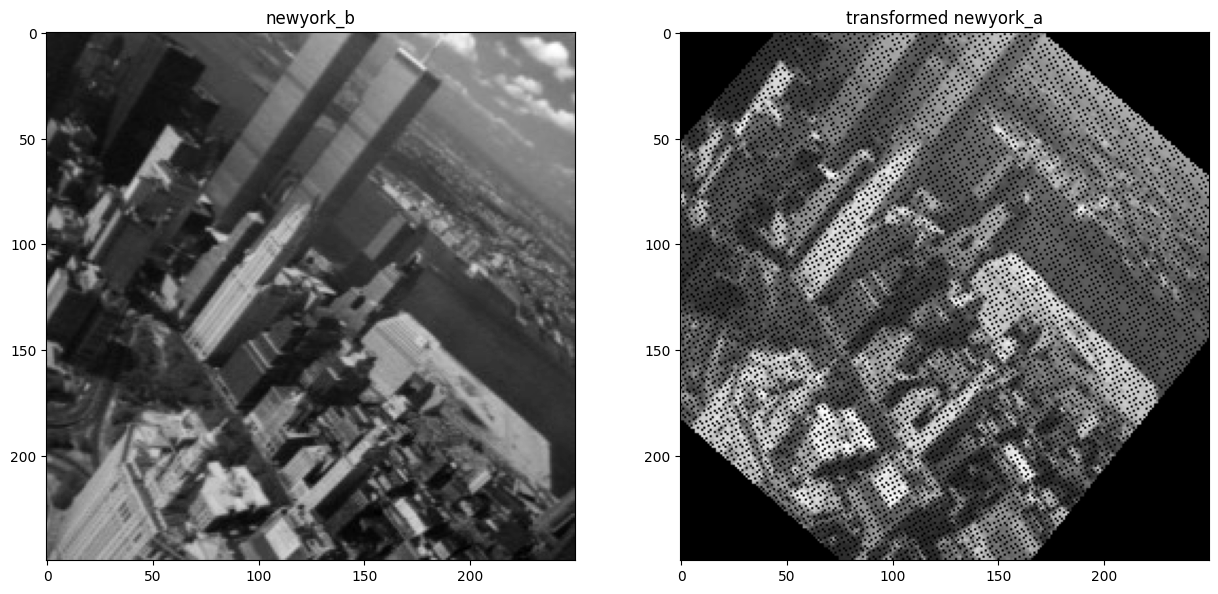

In [190]:
new = warpPerspective(I1, bestH, I1.shape)

#display original images and the new image
fig, axs = plt.subplots(1, 2,figsize=(15,10))
axs[0].imshow(I2,cmap='gray')
axs[0].set_title('newyork_b')
axs[1].imshow(new,cmap='gray')
axs[1].set_title('transformed newyork_a')
plt.show()